# 2025Q1-DAAD-sc-spatial course by Genomics UA  
Session M1S13, 2025-02-24  
Author: Oleksandr Petrenko  

## Setup and data loading

In [19]:
setwd("/research/lab_reiberger/users/opetrenko/tmp")

In [ ]:
# unlink("./outputs", recursive = TRUE)

In [ ]:
suppressMessages(library(Seurat))
suppressMessages(library(Matrix))
suppressMessages(library(dplyr))

Warning message:
“package ‘readr’ was built under R version 4.4.1”


In [28]:
raw_counts <- read.csv("./annotated_BE1500.csv", row.names = 1)

## Creating Seurat object from counts

In [5]:
sparce_matrix <- Reduce(cbind2, lapply(raw_counts, Matrix, sparse = TRUE))

gene_names <- rownames(raw_counts)
cell_names <- names(raw_counts)

dimnames(sparce_matrix) <- list(gene_names, cell_names)

In [6]:
seurat_object <- CreateSeuratObject(counts = sparce_matrix)

In [7]:
seurat_object$celltype <- sapply(colnames(seurat_object@assays$RNA$counts), function(x) strsplit(x, "_")[[1]][2])

## Pre-processing

In [8]:
## subset 1000 cells if your PC is a potato
seurat_object <- subset(seurat_object, downsample = 1000)

In [9]:
seurat_object

An object of class Seurat 
15256 features across 1000 samples within 1 assay 
Active assay: RNA (15256 features, 0 variable features)
 1 layer present: counts

In [10]:
seurat_object <- NormalizeData(seurat_object)
seurat_object <- FindVariableFeatures(seurat_object, selection.method = "vst", nfeatures = 2000)
seurat_object <- ScaleData(seurat_object)
seurat_object <- RunPCA(seurat_object, npcs = 30, verbose = FALSE)
seurat_object <- FindNeighbors(seurat_object, dims = 1:30)
seurat_object <- FindClusters(seurat_object, resolution = 0.5)
seurat_object <- RunUMAP(seurat_object, dims = 1:30)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1000
Number of edges: 31143

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9048
Number of communities: 7
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
12:24:46 UMAP embedding parameters a = 0.9922 b = 1.112

12:24:46 Read 1000 rows and found 30 numeric columns

12:24:46 Using Annoy for neighbor search, n_neighbors = 30

12:24:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:24:46 Writing NN index file to temp file /tmp/RtmppaBvxN/file33519855f85594

12:24:46 Searching Annoy index using 1 thread, search_k = 3000

12:24:46 Annoy recall = 100%

12:24:46 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

## Visualizations

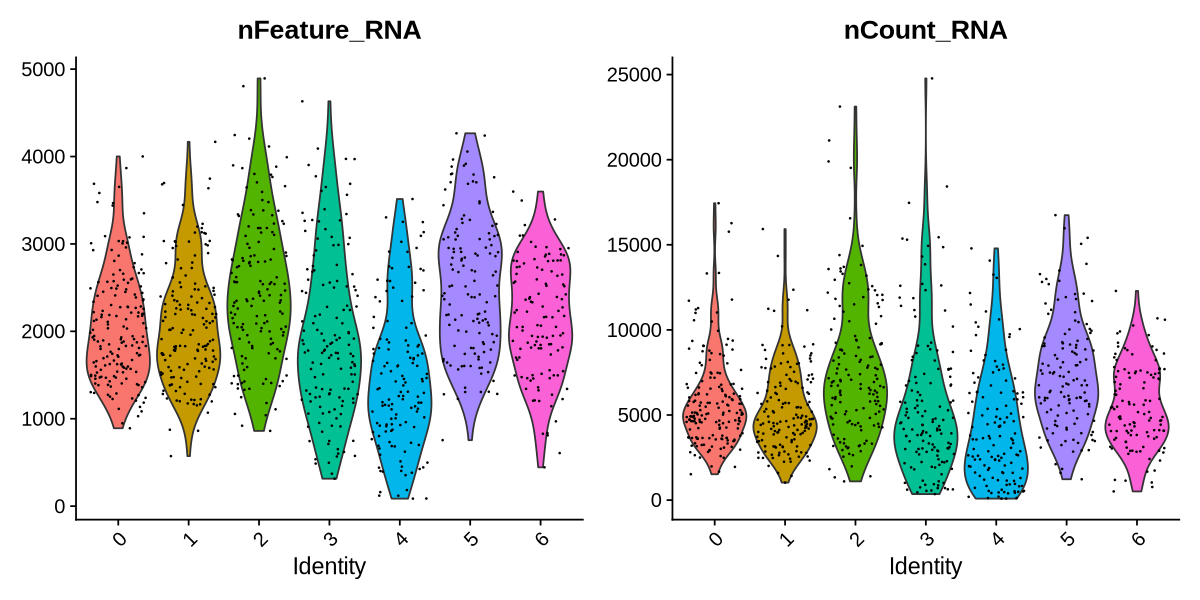

In [11]:
options(repr.plot.width=10, repr.plot.height=5)
VlnPlot(seurat_object, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

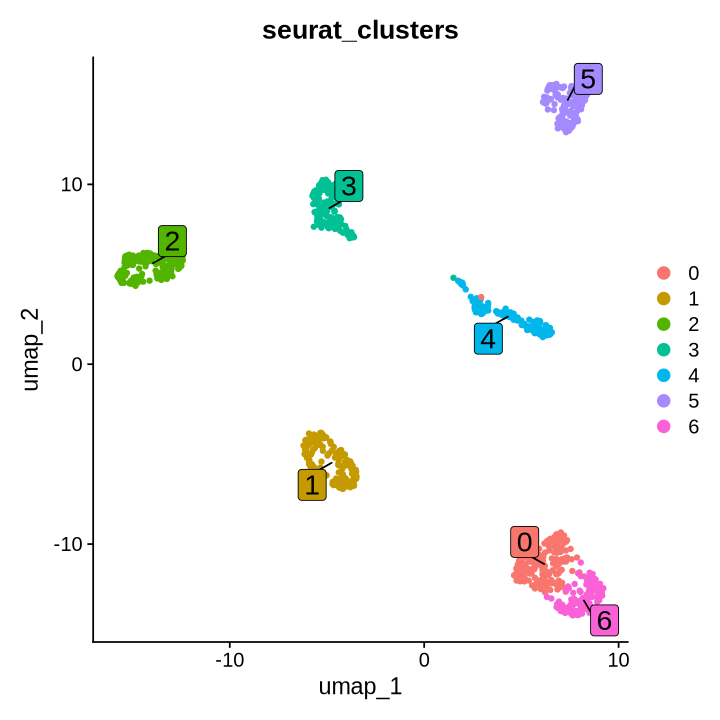

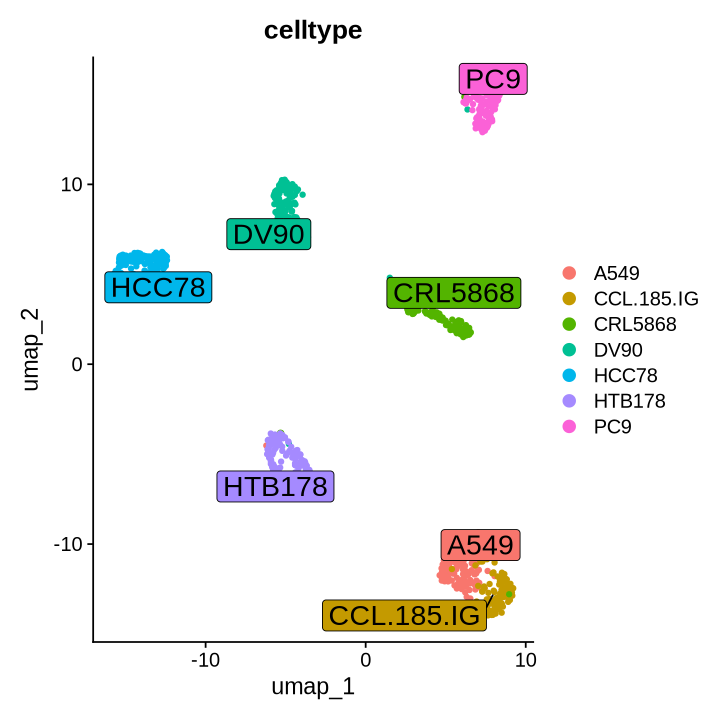

In [12]:
options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seurat_object, label = TRUE, group.by = "seurat_clusters", repel = TRUE, label.box = TRUE, label.size = 6)
DimPlot(seurat_object, label = TRUE, group.by = "celltype", repel = TRUE, label.box = TRUE, label.size = 6)

## Differential expression to identify cluster markers

In [13]:
Idents(seurat_object) <- "celltype"

In [14]:
celltype_markers <- FindAllMarkers(seurat_object, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster A549

Calculating cluster CCL.185.IG

Calculating cluster CRL5868

Calculating cluster DV90

Calculating cluster HCC78

Calculating cluster HTB178

Calculating cluster PC9



In [15]:
celltype_markers_top_5 <- celltype_markers %>% filter(p_val_adj < 0.05) %>% group_by(cluster) %>% top_n(5, avg_log2FC) %>% arrange(cluster, desc(avg_log2FC))

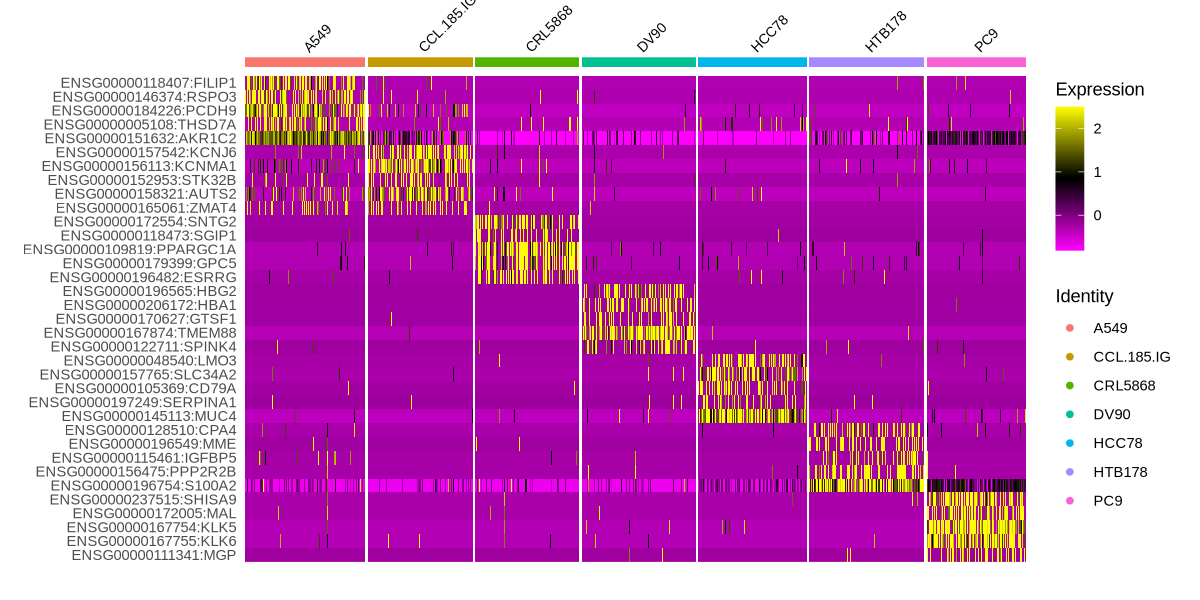

In [16]:
options(repr.plot.width=10, repr.plot.height=5)

DoHeatmap(seurat_object, features = celltype_markers_top_5$gene, group.by = "celltype", assay = "RNA", label = TRUE, size = 3, angle = 45, raster = TRUE)

## Save all visualizations and outputs

In [ ]:
# # create outputs folder if empty
# if (!dir.exists("./outputs")) {
#   dir.create("./outputs")
# }

In [ ]:
# saveRDS(seurat_object, "./outputs/seurat_object_processed.rds")

# # save visualizations as png
# png("./outputs/qc_plots.png", width = 10, height = 5, units = "in", res = 300)
# VlnPlot(seurat_object, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)
# dev.off()

# png("./outputs/umap_cluster_based.png", width = 6, height = 6, units = "in", res = 300)
# DimPlot(seurat_object, label = TRUE, group.by = "seurat_clusters", repel = TRUE, label.box = TRUE, label.size = 6)
# dev.off()

# png("./outputs/umap_known_celltypes.png", width = 6, height = 6, units = "in", res = 300)
# DimPlot(seurat_object, label = TRUE, group.by = "celltype", repel = TRUE, label.box = TRUE, label.size = 6)
# dev.off()

# # save celltype markers heatmap
# png("./outputs/heatmap_cluster_markers.png", width = 10, height = 5, units = "in", res = 300)
# DoHeatmap(seurat_object, features = celltype_markers_top_5$gene, group.by = "celltype", assay = "RNA", label = TRUE, size = 3, angle = 45, raster = TRUE)
# dev.off()

# # save celltype markers (top 5)
# write.csv(celltype_markers_top_5, "./outputs/celltype_markers_top_5.csv", row.names = FALSE)

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2